# CycleGAN for Image Class-to-Class Translation

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets torch_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.1 MB/s eta 0:

In [2]:
# Import libraries
import os
import numpy as np
import itertools

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchsummary import summary
from torch_snippets import *

from PIL import Image

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Tue Apr  9 07:56:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Download and extract the dataset
if not os.path.exists('apples_oranges'):
    !wget -q https://www.dropbox.com/s/2xltmolfbfharri/apples_oranges.zip
    !unzip -q apples_oranges.zip -d apples_oranges

In [5]:
# Set the image size for the model
IMAGE_SIZE = 256

# Create a transformation pipeline for the dataset
transform = T.Compose([
    T.Resize(int(IMAGE_SIZE * 1.33)), # Resize to a larger image
    T.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize to [-1, 1]
])

In [6]:
# Create Dataset class to fetch images from the dataset
class CycleGANDataset(Dataset):
    def __init__(self, apples, oranges):
        self.apples = Glob(apples)
        self.oranges = Glob(oranges)

    def __getitem__(self, idx):
        apple = self.apples[idx % len(self.apples)]
        orange = choose(self.oranges)
        apple = Image.open(apple).convert('RGB')
        orange = Image.open(orange).convert('RGB')
        return apple, orange

    def __len__(self):
        return max(len(self.apples), len(self.oranges))

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        sources, targets = list(zip(*batch))
        sources = torch.cat([transform(image)[None] for image in sources], 0).to(device).float()
        targets = torch.cat([transform(image)[None] for image in targets], 0).to(device).float()
        return sources, targets

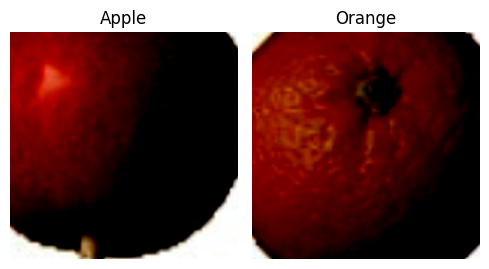

In [15]:
# Create train and validation datasets
train_ds = CycleGANDataset('apples_oranges/apples_train', 'apples_oranges/oranges_train')
val_ds = CycleGANDataset('apples_oranges/apples_test', 'apples_oranges/oranges_test')

# Create a function to retrieve the dataloaders
def load_data(batch_size = 32):
    train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=train_ds.collate_fn)
    val_dl = DataLoader(val_ds, batch_size=5, shuffle=True, collate_fn=val_ds.collate_fn)
    return train_dl, val_dl

# Plot a sample image from the dataloader
train_dl, val_dl = load_data()
apple, orange = next(iter(train_dl))
subplots([apple[0], orange[0]], nc=2, titles=['Apple', 'Orange'])

In [16]:
# Create a function to initialize weights of the model
def weights_init_normal(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
        if hasattr(model, "bias") and model.bias is not None:
            torch.nn.init.constant_(model.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(model.bias.data, 0.0)

In [17]:
# Create a class for the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


# Create a class for the Generator model
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super().__init__()
        out_features = 64
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)

    def forward(self, x):
        return self.model(x)


# Create a class for the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        channels = 3

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, x): # Input shape: (batch_size, 3, 256, 256) Batch of images
        return self.model(x)

In [18]:
# Create a mock-up Discriminator model and print summary
discriminator = Discriminator().to(device)
summary(discriminator, [(3, IMAGE_SIZE, IMAGE_SIZE)])

# Create a mock-up Generator model and print summary
generator = GeneratorResNet().to(device)
summary(generator, (3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 16, 16]           --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        3,136
|    └─LeakyReLU: 2-2                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-3                       [-1, 128, 64, 64]         131,200
|    └─InstanceNorm2d: 2-4               [-1, 128, 64, 64]         --
|    └─LeakyReLU: 2-5                    [-1, 128, 64, 64]         --
|    └─Conv2d: 2-6                       [-1, 256, 32, 32]         524,544
|    └─InstanceNorm2d: 2-7               [-1, 256, 32, 32]         --
|    └─LeakyReLU: 2-8                    [-1, 256, 32, 32]         --
|    └─Conv2d: 2-9                       [-1, 512, 16, 16]         2,097,664
|    └─InstanceNorm2d: 2-10              [-1, 512, 16, 16]         --
|    └─LeakyReLU: 2-11                   [-1, 512, 16, 16]         --
|    └─ZeroPad2d: 2-12                   [-1, 512, 17, 17]       

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 3, 256, 256]         --
|    └─ReflectionPad2d: 2-1                   [-1, 3, 262, 262]         --
|    └─Conv2d: 2-2                            [-1, 64, 256, 256]        9,472
|    └─InstanceNorm2d: 2-3                    [-1, 64, 256, 256]        --
|    └─ReLU: 2-4                              [-1, 64, 256, 256]        --
|    └─Conv2d: 2-5                            [-1, 128, 128, 128]       73,856
|    └─InstanceNorm2d: 2-6                    [-1, 128, 128, 128]       --
|    └─ReLU: 2-7                              [-1, 128, 128, 128]       --
|    └─Conv2d: 2-8                            [-1, 256, 64, 64]         295,168
|    └─InstanceNorm2d: 2-9                    [-1, 256, 64, 64]         --
|    └─ReLU: 2-10                             [-1, 256, 64, 64]         --
|    └─ResidualBlock: 2-11                    [-1, 256, 64, 64]         --
|    |  

In [19]:
# Create a function to train the Discriminator
def train_discriminator(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    real_data, fake_data = data
    loss_real = criterion(model(real_data), torch.ones(len(real_data), 1, 16, 16, dtype=torch.float32).to(device))
    loss_fake = criterion(model(fake_data.detach()), torch.zeros(len(real_data), 1, 16, 16, dtype=torch.float32).to(device))
    loss = (loss_real + loss_fake) / 2
    loss.backward()
    optimizer.step()
    return loss

# Create a function to train the Generator
def train_generator(models, data, criterions, optimizer, lambdas):
    d_a, d_b, g_ab, g_ba = models
    real_a, real_b = data
    criterion_identity, criterion_gan, criterion_cycle = criterions
    lambda_id, lambda_cyc = lambdas

    g_ab.train(), g_ba.train()
    optimizer.zero_grad()

    # Identity loss (G_AB(A) should be A; G_BA(B) should be B
    loss_id_a = criterion_identity(g_ba(real_a), real_a)
    loss_id_b = criterion_identity(g_ab(real_b), real_b)
    loss_identity = (loss_id_a + loss_id_b) / 2

    # GAN loss (real images should be classified as real; fake images should be classified as fake)
    fake_b = g_ab(real_a)
    loss_gan_ab = criterion_gan(d_b(fake_b), torch.ones(len(real_a), 1, 16, 16, dtype=torch.float32).to(device))
    fake_a = g_ba(real_b)
    loss_gan_ba = criterion_gan(d_a(fake_a), torch.ones(len(real_a), 1, 16, 16, dtype=torch.float32).to(device))
    loss_gan = (loss_gan_ab + loss_gan_ba) / 2

    # Cycle-consistency loss (real images should be reconstructed)
    recov_a = g_ba(fake_b)
    loss_cycle_a = criterion_cycle(recov_a, real_a)
    recov_b = g_ab(fake_a)
    loss_cycle_b = criterion_cycle(recov_b, real_b)
    loss_cycle = (loss_cycle_a + loss_cycle_b) / 2

    # Total loss
    loss_g = loss_gan + lambda_cyc * loss_cycle + lambda_id * loss_identity
    loss_g.backward()
    optimizer.step()
    return loss_identity, loss_gan, loss_cycle, loss_g, fake_a, fake_b

In [20]:
# Create a function to save a generated image from the validation set
@torch.no_grad()
def generate_sample(g_ab, g_ba, val_dl):
    data = next(iter(val_dl))
    g_ab.eval()
    g_ba.eval()
    real_a, real_b = data
    fake_b = g_ab(real_a)
    fake_a = g_ba(real_b)

    # arange images along x-axis
    real_a = make_grid(real_a, nrow=5, normalize=True)
    real_b = make_grid(real_b, nrow=5, normalize=True)
    fake_a = make_grid(fake_a, nrow=5, normalize=True)
    fake_b = make_grid(fake_b, nrow=5, normalize=True)

    # arange images along y-axis
    image_grid = torch.cat((real_a, fake_b, real_b, fake_a), 1)

    # plot the image grid
    show(image_grid.detach().cpu().permute(1, 2, 0).numpy(), sz=12)

EPOCH: 1.000  loss_d: 0.218  loss_g: 1.316  loss_gan: 0.372  loss_cycle: 0.068  loss_identity: 0.053  (1839.89s - 16558.97s remaining)

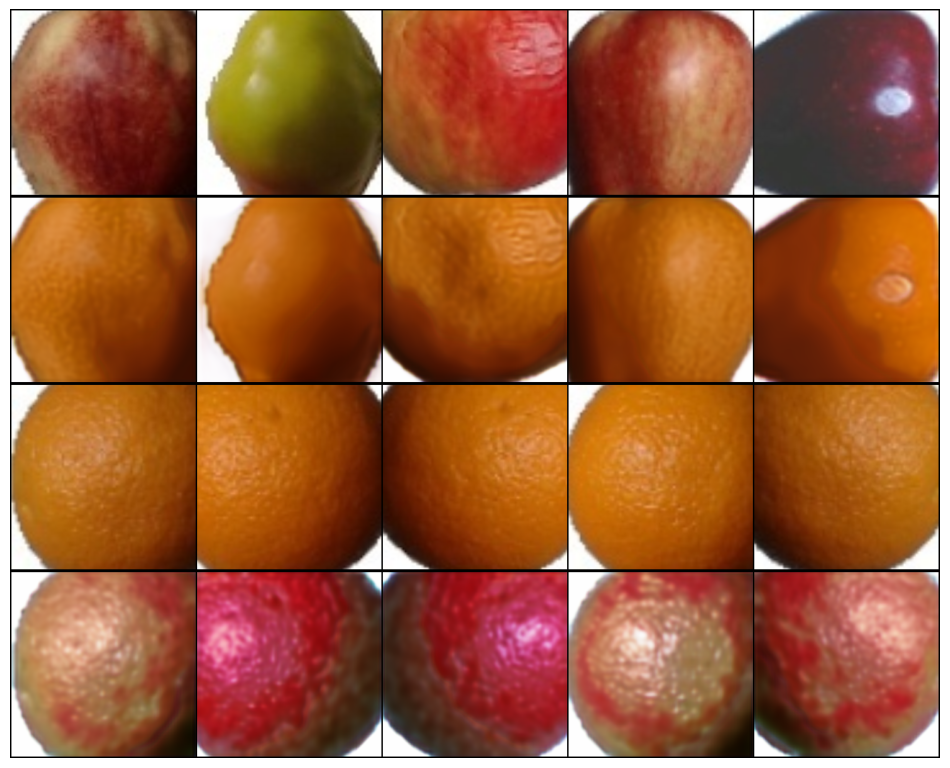

EPOCH: 1.000  loss_d: 0.234  loss_cycle: 0.118  loss_identity: 0.104  loss_gan: 0.485  loss_g: 2.185  (1840.97s - 16568.69s remaining)
EPOCH: 2.000  loss_d: 0.164  loss_g: 1.240  loss_gan: 0.454  loss_cycle: 0.058  loss_identity: 0.042  (3679.72s - 14718.88s remaining)

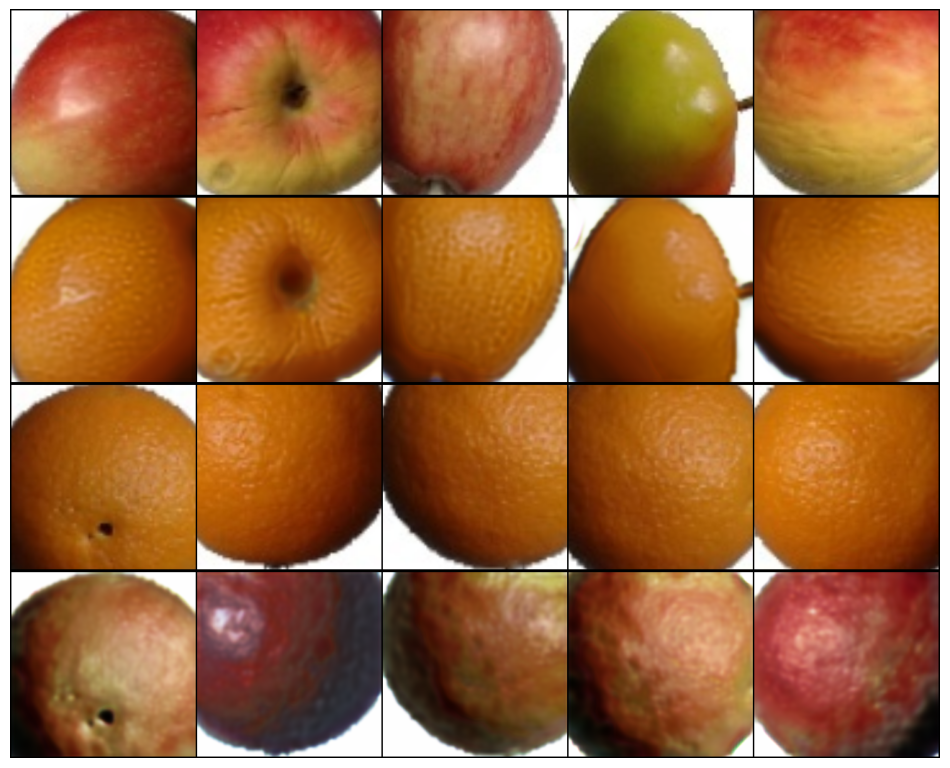

EPOCH: 2.000  loss_d: 0.200  loss_cycle: 0.089  loss_identity: 0.072  loss_gan: 0.501  loss_g: 1.747  (3680.74s - 14722.98s remaining)
EPOCH: 3.000  loss_d: 0.146  loss_g: 1.477  loss_gan: 0.575  loss_cycle: 0.070  loss_identity: 0.040  (5519.68s - 12879.26s remaining)

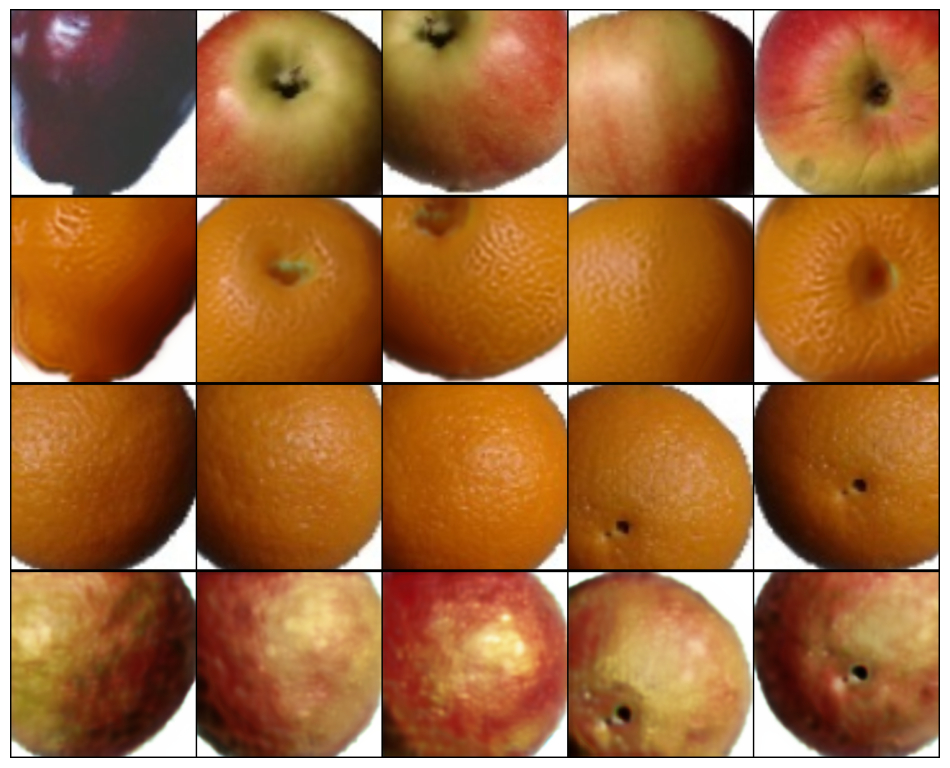

EPOCH: 3.000  loss_d: 0.198  loss_cycle: 0.075  loss_identity: 0.055  loss_gan: 0.491  loss_g: 1.516  (5520.70s - 12881.63s remaining)
EPOCH: 4.000  loss_d: 0.164  loss_g: 1.309  loss_gan: 0.593  loss_cycle: 0.054  loss_identity: 0.036  (7359.61s - 11039.41s remaining)

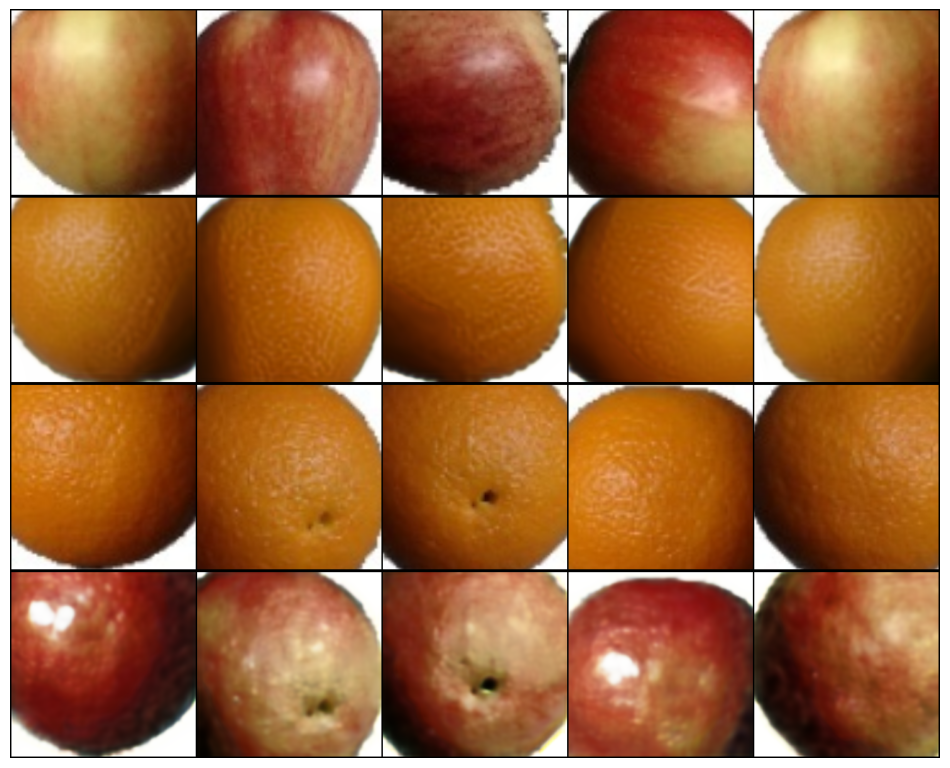

EPOCH: 4.000  loss_d: 0.197  loss_cycle: 0.069  loss_identity: 0.046  loss_gan: 0.490  loss_g: 1.414  (7360.79s - 11041.19s remaining)
EPOCH: 5.000  loss_d: 0.192  loss_g: 0.767  loss_gan: 0.295  loss_cycle: 0.035  loss_identity: 0.024  (9199.63s - 9199.63s remaining)

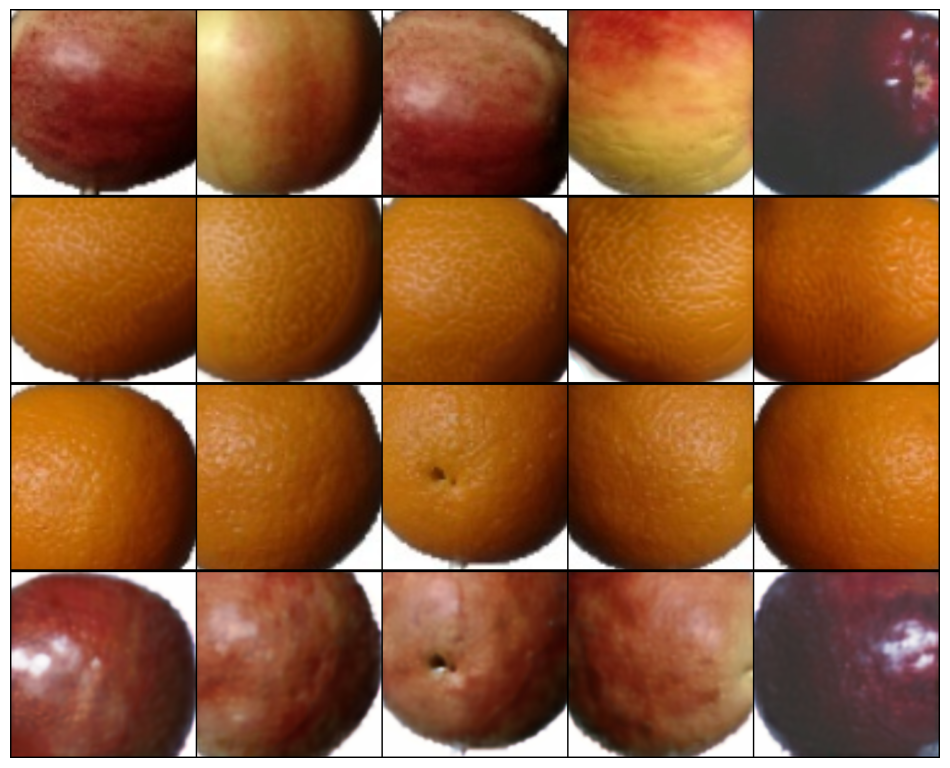

EPOCH: 5.000  loss_d: 0.193  loss_cycle: 0.067  loss_identity: 0.042  loss_gan: 0.493  loss_g: 1.372  (9200.67s - 9200.67s remaining)
EPOCH: 6.000  loss_d: 0.070  loss_g: 1.319  loss_gan: 0.742  loss_cycle: 0.041  loss_identity: 0.033  (11040.65s - 7360.44s remaining)

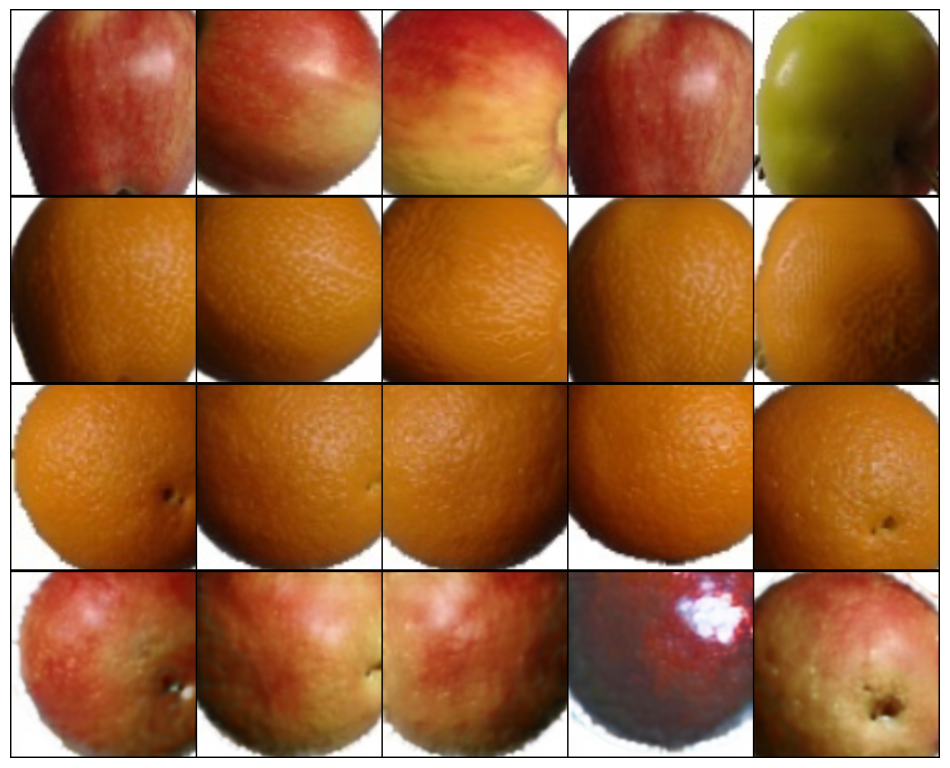

EPOCH: 6.000  loss_d: 0.192  loss_cycle: 0.064  loss_identity: 0.039  loss_gan: 0.495  loss_g: 1.328  (11041.72s - 7361.15s remaining)
EPOCH: 7.000  loss_d: 0.222  loss_g: 1.239  loss_gan: 0.482  loss_cycle: 0.058  loss_identity: 0.035  (12882.06s - 5520.88s remaining)

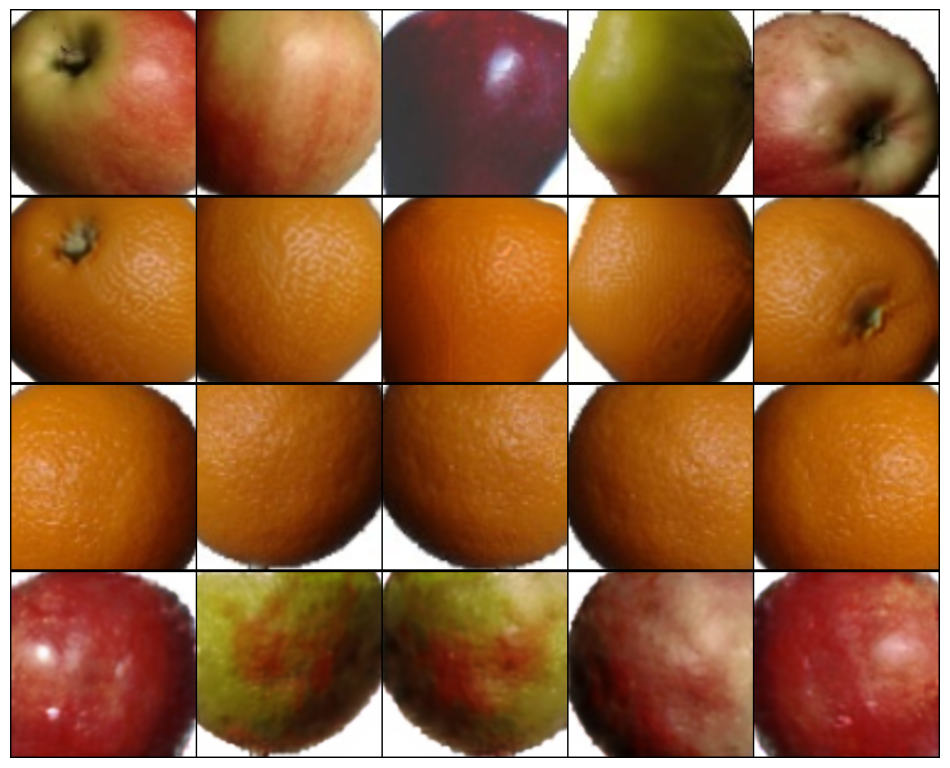

EPOCH: 7.000  loss_d: 0.194  loss_cycle: 0.062  loss_identity: 0.036  loss_gan: 0.486  loss_g: 1.285  (12883.14s - 5521.35s remaining)
EPOCH: 7.394  loss_d: 0.188  loss_g: 1.098  loss_gan: 0.464  loss_cycle: 0.050  loss_identity: 0.028  (13608.41s - 4796.58s remaining)

In [ ]:
# Train the model
d_a = Discriminator().to(device)
d_b = Discriminator().to(device)
g_ab = GeneratorResNet().to(device)
g_ba = GeneratorResNet().to(device)

criterion_identity = nn.L1Loss()
criterion_gan = nn.MSELoss()
criterion_cycle = nn.L1Loss()

optimizer_d_a = optim.Adam(d_a.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d_b = optim.Adam(d_b.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_g = optim.Adam(itertools.chain(g_ab.parameters(), g_ba.parameters()), lr=2e-4, betas=(0.5, 0.999))

lambda_id, lambda_cyc = 5.0, 10.0

train_dl, val_dl = load_data()
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, (real_a, real_b) in enumerate(train_dl):
        loss_identity, loss_gan, loss_cycle, loss_g, fake_a, fake_b = train_generator(
            [d_a, d_b, g_ab, g_ba], [real_a, real_b],
            [criterion_identity, criterion_gan, criterion_cycle],
            optimizer_g, [lambda_id, lambda_cyc]
        )
        loss_d_a = train_discriminator(d_a, [real_a, fake_a], criterion_gan, optimizer_d_a)
        loss_d_b = train_discriminator(d_b, [real_b, fake_b], criterion_gan, optimizer_d_b)
        loss_d = (loss_d_a + loss_d_b) / 2
        log.record(epoch+(i+1)/n, loss_d=loss_d.item(), loss_g=loss_g.item(),
            loss_gan=loss_gan.item(), loss_cycle=loss_cycle.item(),
            loss_identity=loss_identity.item(), end='\r')

    # Generate a sample image every epoch
    generate_sample(g_ab, g_ba, val_dl)

    # Log the average loss for the epoch
    log.report_avgs(epoch+1)

# Plot the loss
log.plot_epochs(['loss_d', 'loss_g', 'loss_gan', 'loss_cycle', 'loss_identity'])